# Bridge Analysis

This notebook demonstrates the use of `PyCBA` in conducting moving load and other analyses relevant to bridge analysis.

In [1]:
import pycba as cba
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

## Example 1 - Moving Load Envelope

This example shows the basic interface for moving a vehicle across the bridge.

Consider a two-span continuous bridge, 50 m long:

In [2]:
L = [25, 25]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0, -1, 0]

and a three-axle vehicle with a 6 t steer axle, 6 m spacing back to the tandem of 12 t axles each with spacing 1.2 m:

In [3]:
axle_spacings = np.array([6, 1.2])
axle_weights = np.array([6, 12, 12]) * 9.81  # t to kN

Now define the `bridge_analysis` object and add the bridge definition and vehicle definitions:

In [4]:
bridge_analysis = cba.BridgeAnalysis()
bridge = bridge_analysis.add_bridge(L, EI, R)
vehicle = bridge_analysis.add_vehicle(axle_spacings, axle_weights)

Examine the vehicle at a single position, when the front axle is at 30.0 m say:

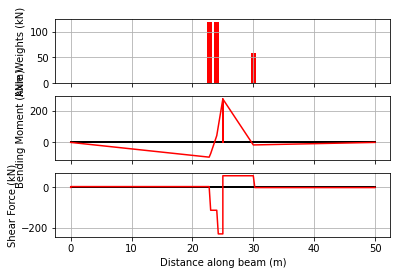

In [5]:
bridge_analysis.static_vehicle(30.0, True);

Now we run the vehicle over the bridge, returning the envelope of results. When run as a python script, the `matplotlib` figure will animate each result when `plot_all=True`.

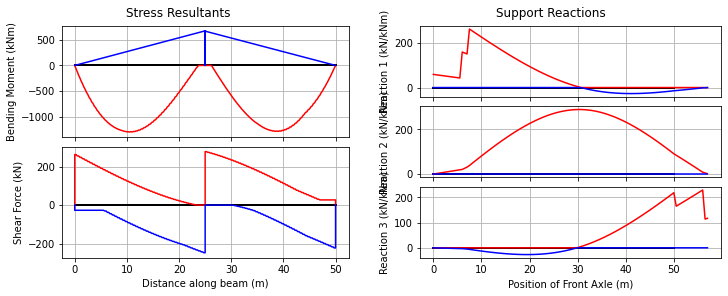

In [6]:
bridge_analysis.run_vehicle(0.5, plot_env=True, plot_all=False);

Alternatively, using the `reverse()` method, we can do an analysis for the vehicle travelling in the reverse direction.

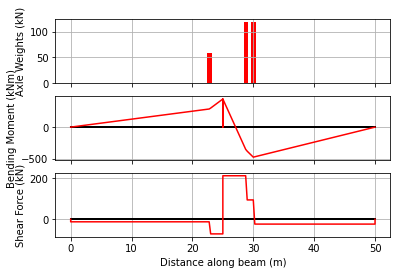

In [7]:
vehicle.reverse()
bridge_analysis.static_vehicle(30.0, True)

## Example 2 - Critical Values and Positions

In [8]:
L = [37]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0]

In [9]:
bridge = cba.BeamAnalysis(L, EI, R)
bridge.npts = 500  # Use more points along the beam members
vehicle = cba.VehicleLibrary.get_m1600(6.25)
bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
env = bridge_analysis.run_vehicle(0.1)

From the envelope, we can extract the critical values of load effects, where they are located, and the vehicle position that caused it:

In [10]:
cvals = bridge_analysis.critical_values(env)

and so if we are interested in the maximum bending moment in particular, we can interogate the results as follows:

In [11]:
pos = cvals["Mmax"]["pos"][0]
at = cvals["Mmax"]["at"]
val = cvals["Mmax"]["val"]
print(f"Max moment is {val} kNm at {at:.2f} m when front axle position is {pos} m")

Max moment is 7809.3 kNm at 20.35 m when front axle position is 29.1 m


and confirm the results with a static analysis with the vehicle at that position:

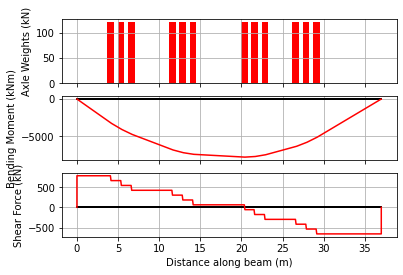

In [12]:
bridge_analysis.static_vehicle(pos, True);

# Example 3 - Critical M1600 Positions

Here we consider the positioning of the M1600 vehicle to obtain maximum bending moment in simply-supported bridges of spans 15 to 40~m

First create the array to store the results and the span lengths.

In [13]:
critical_axle_positions = []
critical_beam_location = []
spans = np.arange(15,40.5,0.5)

Next, create unchanging variables outside the loop, and then loop to find the critical positions:

In [14]:
vehicle = cba.VehicleLibrary.get_m1600(6.25)
for L in spans:
    EI = 30 * 1e11 * 1e-6
    R = [-1, 0, -1, 0]
    bridge = cba.BeamAnalysis([L], EI, R)
    bridge.npts = 500  # Use more points along the beam members    
    bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
    env = bridge_analysis.run_vehicle(0.05)
    cvals = bridge_analysis.critical_values(env)
    critical_axle_positions.append(cvals["Mmax"]["pos"][0])
    critical_beam_location.append(cvals["Mmax"]["at"])

And plot the results

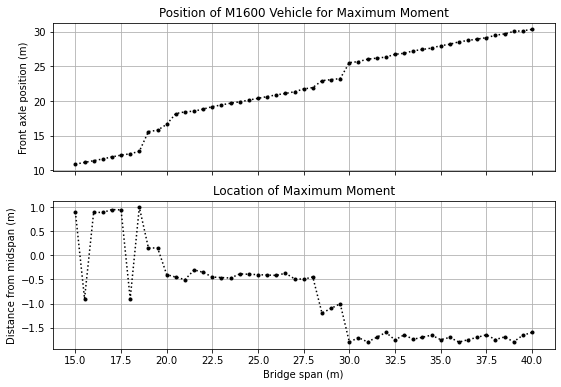

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,6), sharex=True)
ax1.plot(spans,critical_axle_positions,'k.:')
ax1.grid(which="both")
ax1.set_ylabel("Front axle position (m)")
ax1.set_title("Position of M1600 Vehicle for Maximum Moment");

ax2.plot(spans,spans/2 - critical_beam_location,'k.:')
ax2.grid(which="both")
ax2.set_title("Location of Maximum Moment")
ax2.set_ylabel("Distance from midspan (m)")
ax2.locator_params(axis='x', nbins=12)
ax2.set_xlabel("Bridge span (m)");

## Example 4 - Access Assessment for Single Vehicles

This example considers the relative load effects between a reference vehicle and another vehicle. This type of analysis is commonly done to assess whether a new vehicle type would impose more onerous load effects on a bridge than some existing reference vehicle.

In [16]:
L = [25, 25]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0, -1, 0]
bridge = cba.BeamAnalysis(L, EI, R)

Here we use a suite of reference vehicles (the Australian ABAG B-doubles) to create a "super-envelope": an envelope of the load effect envelopes from each of the 3 reference vehicles.

Firstly, obtain the vehicle from the `VehicleLibrary` and analyze for the envelope, appending it to the list of envelopes.

In [17]:
envs = []
for i in range(3):
    vehicle = cba.VehicleLibrary.get_abag_bdouble(i)
    bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
    envs.append(bridge_analysis.run_vehicle(0.5))

Next, create a new zero-like envelope and augment it with the stored envelopes, such that the result is the envelope of envelopes:

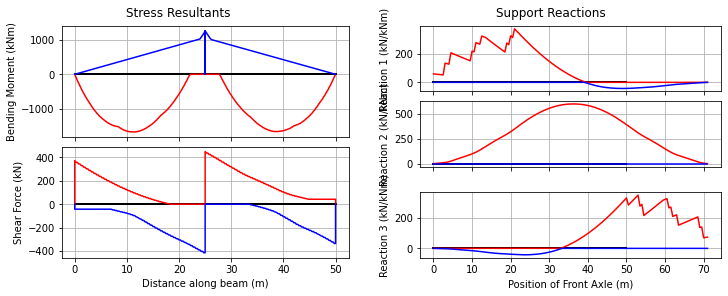

In [18]:
envenv = cba.Envelopes.zero_like(envs[0])
for e in envs:
    envenv.augment(e)
bridge_analysis.plot_envelopes(envenv)

Now analyze the permit application vehicle; here just taking an example vehicle from the `VehicleLibrary`:

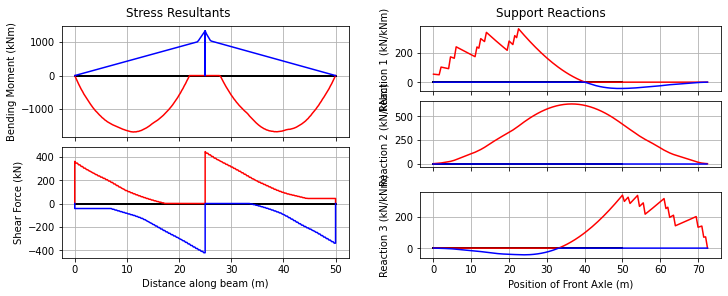

In [19]:
vehicle = cba.VehicleLibrary.get_example_permit()
bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
trial_env = bridge_analysis.run_vehicle(0.5, True)

And we can plot the ratios of trial to reference envelopes

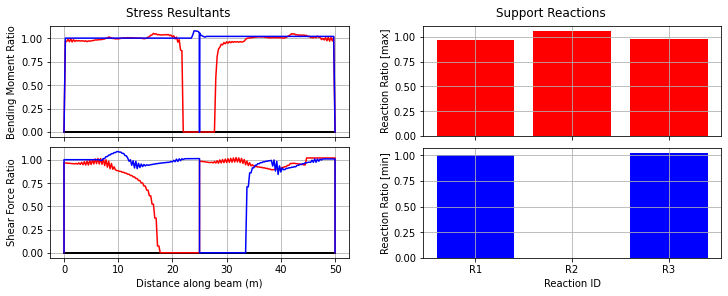

In [20]:
envr = bridge_analysis.envelopes_ratios(trial_env, envenv)
bridge_analysis.plot_ratios(envr)

As can be seen in this case, the central support reaction is greater than 1.0, as is the hogging moment (by about 7%). This vehicle is unlikely to be granted a permit as a result.

## Example 5 - Access Assessment for Vehicle Spacings

Using the `Vehicle.from_convoy` method we create a `Vehicle` object representing a sequence of vehicles at different spacings. 
Here, we will explore different prime mover and platform trailer combinations commonly adopted in "superload" transport convoys.

First set up the bridge as per Exmple 3:

In [21]:
L = [25, 25]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0, -1, 0]
bridge = cba.BeamAnalysis(L, EI, R)

And now define the components of the superload:

In [22]:
prime_mover = cba.Vehicle(axle_spacings=np.array([3.2,1.2]),
                          axle_weights=np.array([6.5,9.25,9.25])*9.81)
platform_trailer = cba.Vehicle(axle_spacings=np.array([1.8,]*9),
                               axle_weights=np.array([12]*10)*9.81)

Three spacing combinations are explored for the convoy comprising of two front prime movers followed by two platform trailers and then two back prime movers.

In [23]:
inter_spaces = [np.array([5.0,6.3,8.0,6.0,4.8]),
               np.array([4.8,6.0,7.5,6.0,5.0]),
               np.array([5.0,6.3,8.0,6.3,5.0])]

Now, similar to Example 3, run the analysis for each set of spacings and store the envelopes:

In [24]:
envs = []
for s in inter_spaces:
    vehicle = cba.Vehicle.from_convoy([prime_mover]*2 + [platform_trailer]*2 + [prime_mover]*2,s)
    bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
    envs.append(bridge_analysis.run_vehicle(0.1))

And now augment the envelopes to get the overall envelope:

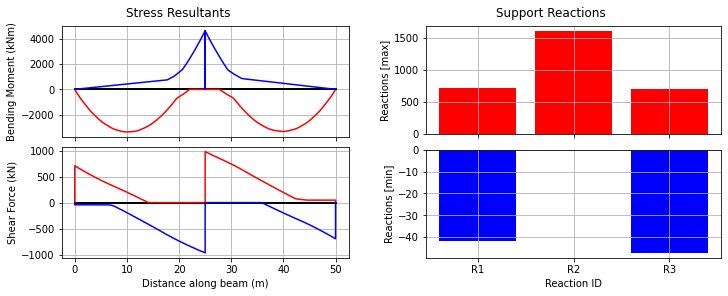

In [25]:
envenv = cba.Envelopes.zero_like(envs[0])
for e in envs:
    envenv.augment(e)
bridge_analysis.plot_envelopes(envenv)

Note that this overall envelope can only show the extremes of reaction values, since the time histories of reactions are not compatible.